# Notebook 8: Reversible Jump MCMC (Advanced Implementation)

本 notebook 示範如何使用 `infodynamics-jax` 實現完整的 RJ-MCMC，包括 rank-1 updates 和高效的矩陣緩存。

**學習目標：**
- 理解 RJ-MCMC 在模型空間和參數空間中的採樣
- 實現高效的 rank-1 birth/death moves
- 使用 infodynamics-jax 的組件重構自定義 MCMC 實現
- 可視化模型複雜度的後驗分布

**主要概念：**
- **RJ-MCMC**: 跨維度 MCMC，誘導點數量 M 是推斷的
- **Rank-1 Updates**: 高效更新 Cholesky 分解和相關矩陣
- **VFE (Variational Free Energy)**: Titsias 2009 的變分下界
- **貝葉斯模型平均**: 使用後驗分布進行預測

**設計說明：**
這個 notebook 展示了如何在 `infodynamics-jax` 的基礎上實現高性能的 RJ-MCMC。
我們使用庫的核心組件（Phi, kernels, VFE），同時保留自定義的高效更新邏輯。

**更新日誌：**
- 修復了 JIT 編譯問題（移除 ）
- 使用 mask 方法處理動態大小的誘導點
- 改善了代碼穩定性和可維護性

In [1]:
# Setup path and imports
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
candidates = [cwd, *cwd.parents]
for p in candidates:
    if (p / 'infodynamics_jax').is_dir():
        sys.path.insert(0, str(p))
        sys.path.insert(0, str(p / 'examples'))
        sys.path.insert(0, str(p / 'examples' / 'utils'))
        break

import os
# 修復 Metal GPU 支持問題：強制使用 CPU（Metal 不支持 float64）
# 必須在導入 JAX 之前設置環境變量
os.environ['JAX_PLATFORMS'] = 'cpu'

import jax
import jax.numpy as jnp
import jax.random as jrand
import jax.scipy as jsp
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from matplotlib.gridspec import GridSpec
from dataclasses import dataclass
from functools import partial
import time

# 再次確認使用 CPU（保險起見）
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# Import infodynamics-jax components
from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels import rbf as rbf_kernel
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.inference.optimisation.vfe import vfe_objective

print(f"JAX version: {jax.__version__}")
print(f"JAX platform: {jax.default_backend()}")
print("Using infodynamics-jax components for RJ-MCMC implementation")

JAX version: 0.8.2
JAX platform: cpu
Using infodynamics-jax components for RJ-MCMC implementation


## 使用 infodynamics-jax 重構版本

以下展示如何使用 `infodynamics-jax` 的組件重構原始代碼：

**重構重點：**
1. ✅ 使用 `infodynamics_jax.gp.kernels.rbf` 替代自定義 `rbf_kernel`
2. ✅ 使用 `Phi` 和 `KernelParams` 管理參數
3. ✅ 保留高效的 rank-1 updates（實現細節，與庫核心無關）
4. ✅ 保留 MCMC 特定邏輯（RJ moves, HMC 等）

**注意：** Rank-1 updates、RJ moves、HMC 邏輯等是實現細節，庫不提供這些，所以保留原實現。

In [2]:
# ============================================================
# 重構版本：使用 infodynamics-jax 組件
# ============================================================

# 注意：我們已經在 Cell 1 中導入了 infodynamics-jax 組件

# ============================================================
# 0) 使用 library 的 RBF kernel（替代自定義 kernel）
# ============================================================

# 原始版本使用：def rbf_kernel(X1, X2, log_ls, log_sf)
# 重構為：使用 infodynamics_jax.gp.kernels.rbf

# Helper function: 將 log 參數轉換為 KernelParams
def log_params_to_kernel_params(log_ls, log_sf):
    """將 log 參數轉換為 KernelParams（library 格式）"""
    return KernelParams(
        lengthscale=jnp.exp(log_ls),
        variance=jnp.exp(2.0 * log_sf)
    )

# 使用 library 的 kernel（替代原來的 rbf_kernel）
# 在需要使用的地方，我們會這樣調用：
#   kernel_params = log_params_to_kernel_params(log_ls, log_sf)
#   K = rbf_kernel(X1, X2, kernel_params)  # library 的 rbf_kernel

# softmax_stable 保持不變（這是通用工具函數）
@jax.jit
def softmax_stable(x, temp=1.0):
    z = x / temp
    z = z - jnp.max(z)
    e = jnp.exp(z)
    return e / (jnp.sum(e) + 1e-30)

In [3]:
# ============================================================
# 1) State 類：使用 Phi 管理參數（保留緩存矩陣）
# ============================================================

@jax.tree_util.register_pytree_node_class
@dataclass
class RJState:
    """
    RJ-MCMC state with cached matrices for efficient updates.
    
    使用 infodynamics-jax 的 Phi 來管理結構參數，
    同時保留緩存矩陣以提高效率。
    """
    phi: Phi                    # infodynamics-jax Phi (kernel_params, Z, likelihood_params)
    M: jnp.ndarray              # () int32 - number of active inducing points
    Z_buf: jnp.ndarray          # (M_max,) int32 - buffer of inducing point indices
    
    # Cached matrices for efficient rank-1 updates
    Lm: jnp.ndarray             # (M_max, M_max) - Cholesky of K_ZZ
    A: jnp.ndarray              # (M_max, N) - K_ZZ^{-1} @ K_ZX
    LB: jnp.ndarray             # (M_max, M_max) - Cholesky of B = I + (1/sn2) * A @ A.T
    
    # Cached VFE components
    logdetB: jnp.ndarray        # () - log determinant of B
    v: jnp.ndarray              # (M_max,) - solution vector for VFE
    vnorm2: jnp.ndarray         # () - ||v||^2
    sumA2: jnp.ndarray          # () - sum of squared A elements
    elbo: jnp.ndarray           # () - VFE/ELBO value

    def tree_flatten(self):
        children = (
            self.phi, self.M, self.Z_buf,
            self.Lm, self.A, self.LB,
            self.logdetB, self.v, self.vnorm2, self.sumA2, self.elbo
        )
        return children, None

    @classmethod
    def tree_unflatten(cls, aux, children):
        return cls(*children)
    
    @property
    def theta(self):
        """兼容原始代碼：從 phi 提取 theta (D+2,)"""
        D = self.phi.Z.shape[1] if len(self.phi.Z.shape) > 1 else 1
        log_ls = jnp.log(self.phi.kernel_params.lengthscale)
        log_sf = 0.5 * jnp.log(self.phi.kernel_params.variance)
        log_sn = 0.5 * jnp.log(self.phi.likelihood_params["noise_var"])
        return jnp.concatenate([log_ls.flatten()[:D], jnp.array([log_sf, log_sn])])

In [4]:
# ============================================================
# 2) Core VFE & State Building (Regression)
# ============================================================

@jax.jit
def compute_elbo_from_cache(N, sn2, sf2, y2, logdetB, vnorm2, sumA2):
    """
    Compute VFE ELBO for regression from cached scalar statistics.
    Formula based on Titsias 2009.
    """
    return -0.5 * (
        N * jnp.log(2.0 * jnp.pi) +
        N * jnp.log(sn2) +
        logdetB +
        (y2 / sn2 - vnorm2) +
        (N * sf2 - sumA2) / sn2
    )

@partial(jax.jit, static_argnames=("kernel_fn",))
def build_full_state(theta, Z_buf, M, X, y, kernel_fn, jitter=1e-6):
    """
    Build full RJState with all cached matrices from scratch.
    """
    N, D = X.shape
    log_ls, log_sf, log_sn = theta[:D], theta[D], theta[D+1]
    sn2 = jnp.exp(2.0 * log_sn)
    sf2 = jnp.exp(2.0 * log_sf)
    y = y.reshape(-1, 1)
    y2 = jnp.sum(y**2)
    
    M_val = M.astype(jnp.int32)
    M_max = Z_buf.shape[0]
    mask = (jnp.arange(M_max, dtype=jnp.int32) < M_val).astype(X.dtype)
    
    kernel_params = KernelParams(lengthscale=jnp.exp(log_ls), variance=sf2)
    Z_full = X[Z_buf]
    
    Kuu_raw = kernel_fn(Z_full, Z_full, kernel_params)
    Kuu = Kuu_raw * mask[:, None] * mask[None, :] + jnp.diag(1.0 - mask) + jitter * jnp.eye(M_max)
    Lm = jsp.linalg.cholesky(Kuu, lower=True)
    
    Kuf_raw = kernel_fn(Z_full, X, kernel_params)
    Kuf = Kuf_raw * mask[:, None]
    A = jsp.linalg.solve_triangular(Lm, Kuf, lower=True)
    
    # B = I + (1/sn2) * A @ A.T
    B = jnp.eye(M_max) + (1.0 / sn2) * (A @ A.T)
    LB = jsp.linalg.cholesky(B, lower=True)
    
    logdetB = 2.0 * jnp.sum(jnp.log(jnp.diag(LB)))
    
    # v = LB^{-1} (1/sn2) A y
    rhs = (1.0 / sn2) * (A @ y).reshape(-1)
    v = jsp.linalg.solve_triangular(LB, rhs[:, None], lower=True).reshape(-1)
    vnorm2 = jnp.sum(v**2)
    sumA2 = jnp.sum(A**2)
    
    elbo = compute_elbo_from_cache(N, sn2, sf2, y2, logdetB, vnorm2, sumA2)
    
    phi = Phi(kernel_params=kernel_params, Z=Z_full, likelihood_params={"noise_var": sn2}, jitter=jitter)
    
    return RJState(phi, M, Z_buf, Lm, A, LB, logdetB, v, vnorm2, sumA2, elbo)


In [5]:
# ============================================================
# 3) Priors - 保持不變
# ============================================================

@jax.jit
def log_prior_theta(theta):
    lp_ls = -0.5 * jnp.sum(((theta[:-2] + 2.0) / 1.2) ** 2)
    lp_sf = -0.5 * (theta[-2] / 1.5) ** 2
    lp_sn = -0.5 * ((theta[-1] + 2.0) / 1.0) ** 2
    return lp_ls + lp_sf + lp_sn

@jax.jit
def log_prior_M_trunc_geom(M, M_min, M_max, p=0.12):
    m = M - M_min
    valid = (M >= M_min) & (M <= M_max)
    K = M_max - M_min + 1
    log_unn = jnp.log(p) + m * jnp.log1p(-p)
    logZ = jnp.log1p(-(1.0 - p) ** K)
    return jnp.where(valid, log_unn - logZ, -jnp.inf)

@jax.jit
def log_prior_ordered_Z_given_M(N, M):
    Nf = jnp.array(N, dtype=jnp.float64)
    Mf = jnp.array(M, dtype=jnp.float64)
    return - (jsp.special.gammaln(Nf + 1.0) - jsp.special.gammaln(Nf - Mf + 1.0))

@jax.jit
def log_posterior(state: RJState, N, M_min, M_max, p_geom=0.12):
    """Log posterior using RJState (兼容原始 State 接口)"""
    theta = state.theta  # 使用 property 從 phi 提取
    return (
        state.elbo
        + log_prior_theta(theta)
        + log_prior_M_trunc_geom(state.M, M_min, M_max, p=p_geom)
        + log_prior_ordered_Z_given_M(N, state.M)
    )

In [6]:
# ============================================================
# 5) Rank-1 Birth：使用 library 的 kernel
# ============================================================

@partial(jax.jit, static_argnames=("kernel_fn",))
def birth_rank1_update(state: RJState, new_idx: jnp.ndarray, X, y, kernel_fn=rbf_kernel, jitter=1e-6):
    """
    Birth move using library's kernel function.
    
    重構重點：使用 library 的 kernel_fn 替代原來的 rbf_kernel
    """
    N, D = X.shape
    y = y.reshape(-1, 1)
    y2 = jnp.sum(y * y)

    # 從 phi 提取參數
    theta = state.theta
    log_ls = theta[:D]
    log_sf = theta[D]
    log_sn = theta[D + 1]
    sn2 = jnp.exp(2.0 * log_sn)
    sf2 = jnp.exp(2.0 * log_sf)

    M = state.M.astype(jnp.int32)
    M_max = state.Z_buf.shape[0]
    slot = M

    active = (jnp.arange(M_max, dtype=jnp.int32) < M).astype(X.dtype)

    z_new = X[new_idx].reshape(1, D)
    Z_full = X[state.Z_buf]
    # 使用 library 的 kernel (傳入完整的 buffer 並 masking)
    kernel_params = state.phi.kernel_params
    km = kernel_fn(z_new, Z_full, kernel_params).reshape(-1) * active

    k_ss = sf2 + jitter
    l = jsp.linalg.solve_triangular(state.Lm, km[:, None], lower=True).reshape(-1)
    lam2 = k_ss - jnp.sum(l * l)
    lam = jnp.sqrt(jnp.maximum(lam2, 1e-12))

    Lm_new = state.Lm.at[slot, :].set(l)
    Lm_new = Lm_new.at[slot, slot].set(lam)

    kx = kernel_fn(z_new, X, kernel_params).reshape(-1)
    proj = l @ state.A
    a = (kx - proj) / lam
    A_new = state.A.at[slot, :].set(a)

    a2 = jnp.sum(a * a)

    b = (1.0 / sn2) * (state.A @ a[:, None]).reshape(-1)
    wb = jsp.linalg.solve_triangular(state.LB, b[:, None], lower=True).reshape(-1)

    beta = 1.0 + (1.0 / sn2) * a2
    schur = beta - jnp.sum(wb * wb)
    schur = jnp.maximum(schur, 1e-18)
    lamB = jnp.sqrt(schur)

    LB_new = state.LB.at[slot, :].set(wb)
    LB_new = LB_new.at[slot, slot].set(lamB)

    logdetB_new = state.logdetB + 2.0 * jnp.log(lamB)
    sumA2_new = state.sumA2 + a2

    r = (1.0 / sn2) * jnp.sum(a[:, None] * y)
    uTc = jnp.dot(wb, state.v)
    v_last = (r - uTc) / lamB

    v_new = state.v.at[slot].set(v_last)
    vnorm2_new = state.vnorm2 + v_last * v_last

    elbo_new = compute_elbo_from_cache(N, sn2, sf2, y2, logdetB_new, vnorm2_new, sumA2_new)

    Z_buf_new = state.Z_buf.at[slot].set(new_idx.astype(jnp.int32))
    M_new = (M + jnp.array(1, dtype=jnp.int32)).astype(jnp.int32)
    
    # 更新 Phi (保持 static shape)
    phi_new = Phi(
        kernel_params=state.phi.kernel_params,
        Z=X[Z_buf_new], 
        likelihood_params=state.phi.likelihood_params,
        jitter=state.phi.jitter
    )

    return RJState(phi_new, M_new, Z_buf_new, Lm_new, A_new, LB_new,
                  logdetB_new, v_new, vnorm2_new, sumA2_new, elbo_new)

In [7]:
# ============================================================
# 6) Rank-1 Death：使用 library 的結構
# ============================================================

@partial(jax.jit, static_argnames=("kernel_fn",))
def death_drop_last(state: RJState, X, y, kernel_fn=rbf_kernel):
    """
    Death move (保持邏輯不變，只是更新 Phi)。
    """
    M = state.M.astype(jnp.int32)
    slot = (M - jnp.array(1, dtype=jnp.int32)).astype(jnp.int32)

    lamB = state.LB[slot, slot]
    v_last = state.v[slot]
    a = state.A[slot, :]
    a2 = jnp.sum(a * a)

    logdetB_new = state.logdetB - 2.0 * jnp.log(lamB)
    vnorm2_new = state.vnorm2 - v_last * v_last
    sumA2_new = state.sumA2 - a2

    # Zero out the removed slot
    Lm_new = state.Lm.at[slot, :].set(jnp.zeros_like(state.Lm[slot, :]))
    Lm_new = Lm_new.at[slot, slot].set(1.0)
    A_new = state.A.at[slot, :].set(jnp.zeros_like(state.A[slot, :]))
    LB_new = state.LB.at[slot, :].set(jnp.zeros_like(state.LB[slot, :]))
    LB_new = LB_new.at[slot, slot].set(1.0)
    v_new = state.v.at[slot].set(0.0)

    N, D = X.shape
    y = y.reshape(-1, 1)
    y2 = jnp.sum(y * y)

    theta = state.theta
    log_ls, log_sf, log_sn = theta[:D], theta[D], theta[D + 1]
    sn2 = jnp.exp(2.0 * log_sn)
    sf2 = jnp.exp(2.0 * log_sf)

    elbo_new = compute_elbo_from_cache(N, sn2, sf2, y2, logdetB_new, vnorm2_new, sumA2_new)
    M_new = (M - jnp.array(1, dtype=jnp.int32)).astype(jnp.int32)
    
    # 更新 Phi (保持 static shape)
    phi_new = Phi(
        kernel_params=state.phi.kernel_params,
        Z=X[state.Z_buf], 
        likelihood_params=state.phi.likelihood_params,
        jitter=state.phi.jitter
    )

    return RJState(phi_new, M_new, state.Z_buf, Lm_new, A_new, LB_new,
                  logdetB_new, v_new, vnorm2_new, sumA2_new, elbo_new)

In [8]:
# ============================================================
# 7) Birth pool choose：使用 library 的 kernel
# ============================================================

@partial(jax.jit, static_argnames=("K_pool", "kernel_fn"))
def birth_pool_choose(key, state: RJState, X, y, M_min, M_max,
                      kernel_fn=rbf_kernel,
                      K_pool: int = 32, temp: float = 1.0, p_geom: float = 0.12, jitter=1e-6):
    """
    Choose birth candidate using library's kernel.
    """
    N, D = X.shape
    y = y.reshape(-1, 1)

    M = state.M.astype(jnp.int32)
    M_max_buf = state.Z_buf.shape[0]
    slot_ok = M < jnp.array(M_max, dtype=jnp.int32)

    cand = jrand.randint(key, shape=(K_pool,), minval=0, maxval=N, dtype=jnp.int32)

    active_mask = (jnp.arange(M_max_buf, dtype=jnp.int32) < M)
    active = active_mask.astype(X.dtype)

    def is_dup(i):
        return jnp.any(jnp.where(active_mask, state.Z_buf == i, False))

    theta = state.theta
    log_ls, log_sf, log_sn = theta[:D], theta[D], theta[D + 1]
    sn2 = jnp.exp(2.0 * log_sn)
    sf2 = jnp.exp(2.0 * log_sf)

    lpM_curr = log_prior_M_trunc_geom(M, M_min, M_max, p=p_geom)
    lpM_prop = log_prior_M_trunc_geom(M + 1, M_min, M_max, p=p_geom)
    d_lpM = lpM_prop - lpM_curr

    d_lpz = log_prior_ordered_Z_given_M(N, M + 1) - log_prior_ordered_Z_given_M(N, M)

    Z_all = X[state.Z_buf]
    kernel_params = state.phi.kernel_params

    def score_one(i):
        valid = slot_ok & (~is_dup(i))
        z_new = X[i].reshape(1, D)

        # 使用 library 的 kernel (傳入完整的 buffer 並 masking)
        km = kernel_fn(z_new, Z_all, kernel_params).reshape(-1) * active

        k_ss = sf2 + jitter
        l = jsp.linalg.solve_triangular(state.Lm, km[:, None], lower=True).reshape(-1)
        lam2 = k_ss - jnp.sum(l * l)
        lam = jnp.sqrt(jnp.maximum(lam2, 1e-12))

        kx = kernel_fn(z_new, X, kernel_params).reshape(-1)
        proj = l @ state.A
        a = (kx - proj) / lam
        a2 = jnp.sum(a * a)

        b = (1.0 / sn2) * (state.A @ a[:, None]).reshape(-1)
        wb = jsp.linalg.solve_triangular(state.LB, b[:, None], lower=True).reshape(-1)

        beta = 1.0 + (1.0 / sn2) * a2
        schur = beta - jnp.sum(wb * wb)
        schur = jnp.maximum(schur, 1e-18)

        d_logdetB = jnp.log(schur)

        r = (1.0 / sn2) * jnp.sum(a[:, None] * y)
        uTc = jnp.dot(wb, state.v)
        v_last = (r - uTc) / jnp.sqrt(schur)
        d_vnorm2 = v_last * v_last
        d_sumA2 = a2

        d_elbo = (-0.5) * (d_logdetB - d_vnorm2) + (0.5 / sn2) * d_sumA2
        d_lp = d_elbo + d_lpM + d_lpz

        return jnp.where(valid, d_lp, -jnp.inf)

    deltas = jax.vmap(score_one)(cand)
    probs = softmax_stable(deltas, temp=temp)

    key2 = jrand.split(key, 2)[1]
    j = jrand.choice(key2, a=K_pool, p=probs)
    idx_new = cand[j]
    q_choose = probs[j]
    return idx_new, q_choose

In [9]:
# ============================================================
# 8) RJ step：使用重構後的函數
# ============================================================

@partial(jax.jit, static_argnames=("K_pool", "kernel_fn"))
def rj_step(key, state: RJState, X, y, M_min, M_max,
            kernel_fn=rbf_kernel,
            K_pool: int = 32, temp_birth: float = 1.0, p_geom: float = 0.12, jitter=1e-6):
    """
    RJ step using refactored functions.
    """
    N, D = X.shape
    key, k_move, k_pool, k_acc = jrand.split(key, 4)

    M = state.M.astype(jnp.int32)
    p_birth = jnp.where(M <= M_min, 1.0,
              jnp.where(M >= M_max, 0.0, 0.5))
    do_birth = jrand.uniform(k_move) < p_birth

    lp_curr = log_posterior(state, N, M_min, M_max, p_geom=p_geom)

    def birth_branch():
        idx_new, q_choose = birth_pool_choose(
            k_pool, state, X, y, M_min, M_max,
            kernel_fn=kernel_fn,
            K_pool=K_pool, temp=temp_birth, p_geom=p_geom, jitter=jitter
        )
        prop = birth_rank1_update(state, idx_new, X, y, kernel_fn=kernel_fn, jitter=jitter)
        lp_prop = log_posterior(prop, N, M_min, M_max, p_geom=p_geom)

        M_prop = prop.M.astype(jnp.int32)
        p_birth_rev = jnp.where(M_prop <= M_min, 1.0,
                        jnp.where(M_prop >= M_max, 0.0, 0.5))
        p_death_rev = 1.0 - p_birth_rev

        q_fwd = p_birth * q_choose
        q_bwd = p_death_rev * 1.0

        loga = (lp_prop - lp_curr) + jnp.log(q_bwd + 1e-30) - jnp.log(q_fwd + 1e-30)
        acc = jnp.log(jrand.uniform(k_acc)) < jnp.minimum(0.0, loga)
        return jax.lax.cond(acc, lambda: prop, lambda: state)

    def death_branch():
        can = M > M_min
        def do_death_inner():
            prop = death_drop_last(state, X, y, kernel_fn=kernel_fn)
            lp_prop = log_posterior(prop, N, M_min, M_max, p_geom=p_geom)

            p_death = 1.0 - p_birth
            M_prop = prop.M.astype(jnp.int32)
            p_birth_rev = jnp.where(M_prop <= M_min, 1.0,
                            jnp.where(M_prop >= M_max, 0.0, 0.5))

            q_fwd = p_death * 1.0
            q_bwd = p_birth_rev * (1.0 / jnp.maximum(1.0, (N - M_prop).astype(jnp.float64)))

            loga = (lp_prop - lp_curr) + jnp.log(q_bwd + 1e-30) - jnp.log(q_fwd + 1e-30)
            acc = jnp.log(jrand.uniform(k_acc)) < jnp.minimum(0.0, loga)
            return jax.lax.cond(acc, lambda: prop, lambda: state)

        return jax.lax.cond(can, do_death_inner, lambda: state)

    return jax.lax.cond(do_birth, lambda: birth_branch(), lambda: death_branch())

In [10]:
# ============================================================
# 9) HMC update：保持使用 blackjax（或可選用 library 的 HMC）
# ============================================================

# 注意：HMC 部分可以保持使用 blackjax（這是合理的選擇）
# 或者可以改為使用 infodynamics_jax.inference.sampling.hmc
# 這裡保持原實現，因為它已經很好用

try:
    import blackjax
    BLACKJAX_AVAILABLE = True
except ImportError:
    BLACKJAX_AVAILABLE = False
    print("Warning: blackjax not available. Install with: pip install blackjax")

@partial(jax.jit, static_argnames=("hmc_steps", "kernel_fn"))
def hmc_update_theta(key, state: RJState, X, y, M_min, M_max, p_geom, 
                     hmc_step_size, hmc_steps, kernel_fn=rbf_kernel, jitter=1e-6):
    """
    HMC update for theta using blackjax (or library's HMC if preferred).
    """
    if not BLACKJAX_AVAILABLE:
        raise ImportError("blackjax is required for HMC updates. Install with: pip install blackjax")
    
    N, D = X.shape

    def logprob(theta):
        st = build_full_state(theta, state.Z_buf, state.M, X, y, kernel_fn=kernel_fn, jitter=jitter)
        return log_posterior(st, N, M_min, M_max, p_geom=p_geom)

    hmc = blackjax.hmc(
        logprob,
        step_size=hmc_step_size,
        inverse_mass_matrix=jnp.ones_like(state.theta),
        num_integration_steps=hmc_steps,
    )
    s0 = hmc.init(state.theta)
    s1, _ = hmc.step(key, s0)
    theta_new = s1.position
    return build_full_state(theta_new, state.Z_buf, state.M, X, y, kernel_fn=kernel_fn, jitter=jitter)

In [11]:
# ============================================================
# 10) Main chain：使用重構後的函數
# ============================================================

@partial(
    jax.jit,
    static_argnames=(
        "n_steps",
        "M_min", "M_max", "M_init",
        "K_pool", "theta_every", "hmc_steps",
        "kernel_fn"  # 添加 kernel_fn 為 static argument（函數對象必須是 static）
    ),
)
def run_chain(key, X, y,
              n_steps: int,
              M_min: int,
              M_max: int,
              M_init: int,
              kernel_fn=rbf_kernel,  # 使用 library 的 kernel
              K_pool: int = 32,
              temp_birth: float = 1.0,
              p_geom: float = 0.12,
              theta_every: int = 10,
              hmc_step_size: float = 0.01,
              hmc_steps: int = 5,
              jitter: float = 1e-6):
    """
    Main MCMC chain using refactored functions with infodynamics-jax components.
    """
    N, D = X.shape
    y = y.reshape(-1, 1)

    key, k0 = jrand.split(key, 2)
    perm = jrand.permutation(k0, N).astype(jnp.int32)

    Z_buf = jnp.zeros((M_max,), dtype=jnp.int32)
    Z_buf = Z_buf.at[:M_init].set(perm[:M_init])
    M0 = jnp.array(M_init, dtype=jnp.int32)

    theta0 = jnp.concatenate([
        jnp.full((D,), -2.0, dtype=jnp.float64),
        jnp.array([0.0, -2.0], dtype=jnp.float64)
    ])

    state0 = build_full_state(theta0, Z_buf, M0, X, y, kernel_fn=kernel_fn, jitter=jitter)

    def one_step(carry, t):
        key, state = carry
        key, k_th, k_rj = jrand.split(key, 3)

        do_theta = (t % theta_every) == 0
        state = jax.lax.cond(
            do_theta,
            lambda: hmc_update_theta(k_th, state, X, y, M_min, M_max, p_geom, 
                                     hmc_step_size, hmc_steps, kernel_fn=kernel_fn, jitter=jitter),
            lambda: state
        )

        state = rj_step(
            k_rj, state, X, y, M_min, M_max,
            kernel_fn=kernel_fn,
            K_pool=K_pool, temp_birth=temp_birth, p_geom=p_geom, jitter=jitter
        )

        return (key, state), (state.elbo, state.M, state.theta, state.Z_buf)

    (_, _), hist = jax.lax.scan(one_step, (key, state0), jnp.arange(n_steps, dtype=jnp.int32))
    elbos, Ms, Thetas, Zs = hist

    # prepend init at index 0
    elbos = jnp.concatenate([jnp.asarray([state0.elbo]), elbos], axis=0)
    Ms    = jnp.concatenate([jnp.asarray([state0.M]), Ms], axis=0)
    Thetas= jnp.concatenate([jnp.asarray([state0.theta]), Thetas], axis=0)
    Zs    = jnp.concatenate([jnp.asarray([state0.Z_buf]), Zs], axis=0)

    return elbos, Ms, Thetas, Zs, state0.M

print("重構版本函數已定義（使用 infodynamics-jax 組件）")

重構版本函數已定義（使用 infodynamics-jax 組件）


## 重構完成總結

**已完成的重構：**

✅ **Kernel 函數**：使用 `infodynamics_jax.gp.kernels.rbf` 替代自定義實現  
✅ **State 類**：使用 `Phi` 管理參數，保留緩存矩陣  
✅ **參數管理**：使用 `KernelParams` 統一參數格式  
✅ **build_full_state**：使用 library 的 kernel 和 Phi 結構  
✅ **birth_rank1_update**：使用 library 的 kernel  
✅ **death_drop_last**：使用 library 的 Phi 結構  
✅ **birth_pool_choose**：使用 library 的 kernel  
✅ **rj_step**：使用重構後的函數  
✅ **run_chain**：使用 library 的 kernel 作為參數

**保持不變的部分（合理的實現細節）：**

- Rank-1 updates 邏輯（高效的矩陣更新）
- RJ moves 的 MCMC 邏輯
- Priors 定義（模型特定）
- HMC 使用 blackjax（或可選用 library 的 HMC）

**可視化和數據生成函數：**

可視化函數 `plot_fancy` 和數據生成函數（`generate_step_data` 等）可以直接使用，
因為它們只是使用 `build_full_state`，而我們已經重構了這個函數。

現在可以使用重構版本運行 MCMC 了！

In [12]:
# ============================================================
# 11) Plotting：使用重構後的 build_full_state 和 library kernel
# ============================================================

def plot_fancy(X, y, f_true, elbos, Ms, Thetas, Zs, M_init, burn_in=0, kernel_fn=rbf_kernel):
    """
    Plotting function updated to use refactored build_full_state and library kernel.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)

    elbos_np = np.array(elbos)
    Ms_np = np.array(Ms)
    Thetas_np = np.array(Thetas)
    Zs_np = np.array(Zs)

    Ms_post = Ms_np[burn_in:]
    Thetas_post = Thetas_np[burn_in:]
    Zs_post = Zs_np[burn_in:]

    fig = plt.figure(figsize=(18, 11))
    gs = GridSpec(3, 4, figure=fig, hspace=0.45, wspace=0.35)

    # --- Predictions (post burn) ---
    ax1 = fig.add_subplot(gs[0, :3])
    X_test = np.linspace(X.min() - 0.1, X.max() + 0.1, 500).reshape(-1, 1)

    n_plot = 120
    idxs = np.linspace(0, len(Ms_post) - 1, min(n_plot, len(Ms_post)), dtype=int)

    mus, vars_ = [], []
    for i in idxs:
        M = int(Ms_post[i])
        Z_idx = Zs_post[i][:M].astype(np.int32)
        theta = Thetas_post[i]

        # 使用重構後的 build_full_state（已經使用 library 的 kernel）
        st = build_full_state(
            jnp.array(theta),
            jnp.array(Zs_post[i], dtype=jnp.int32),
            jnp.array(M, dtype=jnp.int32),
            jnp.array(X),
            jnp.array(y).reshape(-1, 1),
            kernel_fn=kernel_fn
        )

        D = X.shape[1]
        log_ls, log_sf = theta[:D], theta[D]
        
        # 使用 library 的 kernel 進行預測
        kernel_params = st.phi.kernel_params
        Ksm = kernel_fn(jnp.array(X_test), jnp.array(X)[Z_idx], kernel_params)

        v = st.v[:M].reshape(-1, 1)
        w = jsp.linalg.solve_triangular(st.LB[:M, :M].T, v, lower=False)
        alpha = jsp.linalg.solve_triangular(st.Lm[:M, :M].T, w, lower=False)

        mu = (Ksm @ alpha).reshape(-1)

        V1 = jsp.linalg.solve_triangular(st.Lm[:M, :M], Ksm.T, lower=True)
        V2 = jsp.linalg.solve_triangular(st.LB[:M, :M], V1, lower=True)
        sf2 = float(st.phi.kernel_params.variance)
        var = sf2 - np.sum(np.array(V1) ** 2, axis=0) + np.sum(np.array(V2) ** 2, axis=0)

        mus.append(np.array(mu))
        vars_.append(np.array(var))

    mu_tot = np.mean(mus, axis=0)
    std_tot = np.sqrt(np.mean(vars_, axis=0) + np.var(mus, axis=0))

    ax1.plot(X_test, f_true(X_test), "k--", lw=1.5, alpha=0.6, label="Truth")
    ax1.plot(X_test, mu_tot, lw=2, label="BMA mean")
    ax1.fill_between(X_test.reshape(-1), mu_tot - 2 * std_tot, mu_tot + 2 * std_tot, alpha=0.2, label="95% CI")
    ax1.scatter(X, y, s=10, alpha=0.35, label="Data")
    ax1.set_title(f"SGPR/VFE RJ-MCMC (posterior from iter {burn_in}+)")
    ax1.legend(loc="upper left")

    ax1_tw = ax1.twinx()
    all_z = []
    thin_z = max(1, len(Ms_post) // 600)
    for i in range(0, len(Ms_post), thin_z):
        M = int(Ms_post[i])
        zidx = Zs_post[i][:M].astype(np.int32)
        all_z.extend(X[zidx].reshape(-1).tolist())
    if len(all_z) > 10:
        try:
            import seaborn as sns
            sns.kdeplot(all_z, ax=ax1_tw, fill=True, alpha=0.15, lw=0, color="gray")
        except ImportError:
            # 如果 seaborn 不可用，跳過 KDE plot
            pass
    ax1_tw.set_yticks([])
    ax1_tw.set_ylabel("Inducing density", rotation=270, labelpad=15)

    # --- Posterior M ---
    ax2 = fig.add_subplot(gs[0, 3])
    ax2.hist(Ms_post, bins=np.arange(Ms_post.min() - 0.5, Ms_post.max() + 1.5, 1),
             density=True, alpha=0.8, color="C1")
    ax2.set_title("Posterior of M (after burn-in)")

    # --- ELBO trace (full) ---
    ax3 = fig.add_subplot(gs[1, 0:2])
    ax3.plot(elbos_np, lw=0.8, color="C2")
    ax3.axvline(x=burn_in, color="k", linestyle="--", alpha=0.5, label="Burn-in")
    ax3.set_title("ELBO trace (full, includes init idx 0)")
    ax3.legend()

    # --- Hyper posteriors ---
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(np.exp(Thetas_post[:, 0]), bins=30, density=True, alpha=0.8, color="C3")
    ax4.set_title("Lengthscale (after burn-in)")

    ax5 = fig.add_subplot(gs[1, 3])
    ax5.hist(np.exp(Thetas_post[:, -1]), bins=30, density=True, alpha=0.8, color="C4")
    ax5.set_title("Noise std (after burn-in)")

    # --- M trace (full) ---
    ax6 = fig.add_subplot(gs[2, :])
    ax6.plot(Ms_np, lw=0.8, label="M", color="C0")
    ax6.axhline(int(M_init), ls=":", lw=1.5, color="red", label=f"init M={int(M_init)}")
    ax6.axvline(x=burn_in, color="k", linestyle="--", alpha=0.5, label="Burn-in")
    ax6.legend()
    ax6.set_title("Model size trace (full, includes init idx 0)")

    plt.tight_layout()
    plt.show()

In [13]:
# ============================================================
# 12) 數據生成函數（擴展版本）
# ============================================================

def generate_step_data(N=1000, seed=42):
    np.random.seed(seed)
    X = np.sort(np.random.uniform(0, 2.0, (N, 1)), axis=0)
    f_true = lambda x: (x > 1.0).astype(float) * 2.0 - 1.0
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

def generate_chirp_data(N=1000, seed=42):
    np.random.seed(seed)
    X = np.sort(np.random.uniform(0, 1.5, (N, 1)), axis=0)
    f_true = lambda x: np.sin(20 * x**1.5)
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

def generate_gap_data(N=1000, seed=42):
    np.random.seed(seed)
    X = np.sort(np.random.uniform(0, 2.0, (N, 1)), axis=0)
    mask = (X < 0.6) | (X > 1.2)
    X = X[mask].reshape(-1, 1)
    f_true = lambda x: x * np.sin(10 * x)
    y = f_true(X) + 0.1 * np.random.randn(len(X), 1)
    return X, y, f_true

# 新增更多 regression datasets
def generate_sine_mix_data(N=1000, seed=42):
    """多頻率正弦混合"""
    np.random.seed(seed)
    X = np.sort(np.random.uniform(-1, 1, (N, 1)), axis=0)
    f_true = lambda x: np.sin(3 * x) + 0.5 * np.cos(5 * x)
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

def generate_multiscale_data(N=1000, seed=42):
    """多尺度函數"""
    np.random.seed(seed)
    X = np.sort(np.random.uniform(-1, 1, (N, 1)), axis=0)
    f_true = lambda x: np.cos(x) + 0.5 * np.cos(3 * x) + 0.25 * np.cos(9 * x)
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

def generate_piecewise_data(N=1000, seed=42):
    """分段連續函數"""
    np.random.seed(seed)
    X = np.sort(np.random.uniform(-1, 1, (N, 1)), axis=0)
    f_true = lambda x: np.where(x < 0, -0.5 * x + 0.2, 0.8 * x - 0.4)
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

def generate_oscillatory_data(N=1000, seed=42):
    """振盪函數"""
    np.random.seed(seed)
    X = np.sort(np.random.uniform(0, 1, (N, 1)), axis=0)
    f_true = lambda x: 0.5 * x + np.exp(-10 * (x - 0.5)**2) * np.cos(30 * x)
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

def generate_bump_data(N=1000, seed=42):
    """局部凸起函數"""
    np.random.seed(seed)
    X = np.sort(np.random.uniform(-1, 1, (N, 1)), axis=0)
    f_true = lambda x: np.exp(-40 * (x - 0.3)**2) + 0.1 * np.sin(10 * x)
    y = f_true(X) + 0.1 * np.random.randn(N, 1)
    return X, y, f_true

print("數據生成函數已定義（包含更多 regression datasets）")

數據生成函數已定義（包含更多 regression datasets）


In [14]:
# ============================================================
# 13) Metrics 計算函數
# ============================================================

def compute_predictive_mean_var(state: RJState, X_test, X_train, kernel_fn=rbf_kernel):
    """
    計算測試點的預測均值和方差（使用單個 state）。
    """
    M = int(state.M)
    Z_idx = state.Z_buf[:M].astype(jnp.int32)
    
    kernel_params = state.phi.kernel_params
    Ksm = kernel_fn(X_test, X_train[Z_idx], kernel_params)
    
    v = state.v[:M].reshape(-1, 1)
    w = jsp.linalg.solve_triangular(state.LB[:M, :M].T, v, lower=False)
    alpha = jsp.linalg.solve_triangular(state.Lm[:M, :M].T, w, lower=False)
    
    mu = (Ksm @ alpha).reshape(-1)
    
    V1 = jsp.linalg.solve_triangular(state.Lm[:M, :M], Ksm.T, lower=True)
    V2 = jsp.linalg.solve_triangular(state.LB[:M, :M], V1, lower=True)
    sf2 = float(state.phi.kernel_params.variance)
    var = sf2 - jnp.sum(V1 ** 2, axis=0) + jnp.sum(V2 ** 2, axis=0)
    
    return mu, var

def compute_bma_predictions(states, X_test, X_train, kernel_fn=rbf_kernel):
    """
    使用貝葉斯模型平均（BMA）計算預測。
    """
    mus = []
    vars_ = []
    for state in states:
        mu, var = compute_predictive_mean_var(state, X_test, X_train, kernel_fn)
        mus.append(np.array(mu))
        vars_.append(np.array(var))
    
    mu_bma = np.mean(mus, axis=0)
    # BMA 方差：平均方差 + 預測方差
    var_bma = np.mean(vars_, axis=0) + np.var(mus, axis=0)
    
    return mu_bma, var_bma

def compute_rmse(y_true, y_pred):
    """計算均方根誤差 (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_mae(y_true, y_pred):
    """計算平均絕對誤差 (MAE)"""
    return np.mean(np.abs(y_true - y_pred))

def compute_nlpd(y_true, mu_pred, var_pred):
    """
    計算負對數預測密度 (Negative Log Predictive Density, NLPD)。
    
    NLPD = -log p(y_true | mu_pred, var_pred)
         = 0.5 * log(2*pi*var) + 0.5 * (y - mu)^2 / var
    """
    # 避免方差為零或負值
    var_pred = np.maximum(var_pred, 1e-10)
    nlpd = 0.5 * np.log(2 * np.pi * var_pred) + 0.5 * (y_true - mu_pred) ** 2 / var_pred
    return np.mean(nlpd)

def compute_r2(y_true, y_pred):
    """計算決定係數 (R²)"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / (ss_tot + 1e-10))

def compute_metrics(y_true, mu_pred, var_pred=None):
    """
    計算所有 regression metrics。
    
    Returns:
        dict: 包含 RMSE, MAE, R², 和 NLPD (如果提供 var_pred) 的字典
    """
    metrics = {
        'RMSE': compute_rmse(y_true, mu_pred),
        'MAE': compute_mae(y_true, mu_pred),
        'R²': compute_r2(y_true, mu_pred),
    }
    
    if var_pred is not None:
        metrics['NLPD'] = compute_nlpd(y_true, mu_pred, var_pred)
    
    return metrics

print("Metrics 計算函數已定義")

Metrics 計算函數已定義


## 使用重構版本運行示例

以下展示如何使用重構後的代碼運行 RJ-MCMC（使用 infodynamics-jax 組件）。

In [15]:
# ============================================================
# 運行測試套件（使用重構版本，包含 metrics）
# ============================================================

def run_test_suite_refactored():
    """Run test suite using refactored code with infodynamics-jax components and metrics."""
    datasets = [
        ("Step Function", generate_step_data, 50),
        ("Chirp Signal", generate_chirp_data, 80),
        ("Gap Interpolation", generate_gap_data, 60),
        ("Sine Mix", generate_sine_mix_data, 60),
        ("Multiscale", generate_multiscale_data, 70),
        ("Piecewise", generate_piecewise_data, 50),
        ("Oscillatory", generate_oscillatory_data, 65),
        ("Bump", generate_bump_data, 55),
    ]

    key = jrand.PRNGKey(42)
    all_results = []

    for name, gen_fn, m_max_hint in datasets:
        print(f"\n{'='*60}")
        print(f"Running Experiment (Refactored): {name}")
        print(f"{'='*60}")

        # 1. Generate Data
        X, y, f_true = gen_fn(N=500)  # 使用較小的 N 以加快速度
        Xj = jnp.array(X, dtype=jnp.float64)
        yj = jnp.array(y, dtype=jnp.float64)

        # 分割訓練和測試集（80/20）
        n_train = int(0.8 * len(X))
        X_train = X[:n_train]
        y_train = y[:n_train]
        X_test = X[n_train:]
        y_test = y[n_train:]
        f_test_true = f_true(X_test)
        
        X_train_j = jnp.array(X_train, dtype=jnp.float64)
        y_train_j = jnp.array(y_train, dtype=jnp.float64)
        X_test_j = jnp.array(X_test, dtype=jnp.float64)

        # 2. Configure MCMC
        burn_in = 200
        n_steps = 1000
        n_samples_for_metrics = 50  # 用於計算 metrics 的樣本數

        t0 = time.time()

        # 3. Run Chain (使用重構版本，傳入 library 的 kernel)
        elbos, Ms, Thetas, Zs, M_init_val = run_chain(
            key, X_train_j, y_train_j,
            n_steps=n_steps,
            M_min=5,
            M_max=m_max_hint,
            M_init=15,
            kernel_fn=rbf_kernel,  # 使用 infodynamics-jax 的 kernel
            K_pool=64,
            temp_birth=1.0,
            p_geom=0.1,
            theta_every=5,
            hmc_step_size=0.01,
            hmc_steps=10
        )
        Ms.block_until_ready()

        runtime = time.time() - t0
        Ms_np = np.array(Ms)
        Ms_post = Ms_np[burn_in:]
        mean_M = Ms_post.mean()

        print(f"[{name}] Finished in {runtime:.2f}s")
        print(f"[{name}] Mean Inducing Points (M): {mean_M:.2f} ± {Ms_post.std():.2f}")

        # 4. 計算 Metrics
        print(f"[{name}] Computing metrics...")
        
        # 從後驗樣本中選擇一些 states 用於 BMA
        post_indices = np.linspace(burn_in, len(Ms) - 1, n_samples_for_metrics, dtype=int)
        states_for_bma = []
        
        for idx in post_indices:
            M_val = int(Ms_np[idx])
            Z_buf_val = Zs[idx]
            theta_val = Thetas[idx]
            state = build_full_state(
                jnp.array(theta_val),
                jnp.array(Z_buf_val, dtype=jnp.int32),
                jnp.array(M_val, dtype=jnp.int32),
                X_train_j,
                y_train_j,
                kernel_fn=rbf_kernel
            )
            states_for_bma.append(state)
        
        # 計算 BMA 預測
        mu_bma, var_bma = compute_bma_predictions(
            states_for_bma, X_test_j, X_train_j, kernel_fn=rbf_kernel
        )
        
        # 計算 metrics
        metrics = compute_metrics(f_test_true.flatten(), mu_bma, var_bma)
        
        print(f"[{name}] Metrics:")
        for metric_name, metric_value in metrics.items():
            print(f"    {metric_name}: {metric_value:.4f}")
        
        all_results.append({
            'name': name,
            'metrics': metrics,
            'mean_M': mean_M,
            'runtime': runtime
        })

        # 5. Visualization (使用重構版本的 plot_fancy)
        print(f"[{name}] Plotting...")
        plot_fancy(X_train, y_train, f_true, elbos, Ms, Thetas, Zs, M_init_val, 
                  burn_in=burn_in, kernel_fn=rbf_kernel)
        
        # 更新 key 以確保每次運行使用不同的隨機種子
        key = jrand.split(key, 1)[0]

    # 6. 總結所有結果
    print(f"\n{'='*60}")
    print("Summary of All Results")
    print(f"{'='*60}")
    print(f"{'Dataset':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'NLPD':<10} {'Mean M':<10} {'Time (s)':<10}")
    print("-" * 80)
    for result in all_results:
        m = result['metrics']
        print(f"{result['name']:<20} {m['RMSE']:<10.4f} {m['MAE']:<10.4f} "
              f"{m['R²']:<10.4f} {m.get('NLPD', 0):<10.4f} "
              f"{result['mean_M']:<10.2f} {result['runtime']:<10.2f}")
    
    return all_results

# 注意：如果需要運行，取消下面的註釋
# if __name__ == "__main__":
#     results = run_test_suite_refactored()

## 快速測試和繪圖示例

以下是一個簡化的測試示例，展示如何運行 RJ-MCMC 並進行可視化。

In [16]:
# ============================================================
# 快速測試：使用重構版本運行小規模示例
# ============================================================

def quick_test():
    """快速測試重構版本的 RJ-MCMC（使用 infodynamics-jax 組件，包含 metrics）"""
    print("=" * 60)
    print("Quick Test: RJ-MCMC with infodynamics-jax")
    print("=" * 60)
    
    # 1. 生成測試數據（簡單的階躍函數）
    print("\n[1/5] Generating test data...")
    X, y, f_true = generate_step_data(N=200, seed=42)  # 使用較小的 N 以加快速度
    
    # 分割訓練和測試集
    n_train = int(0.8 * len(X))
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
    f_test_true = f_true(X_test)
    
    X_train_j = jnp.array(X_train, dtype=jnp.float64)
    y_train_j = jnp.array(y_train, dtype=jnp.float64)
    X_test_j = jnp.array(X_test, dtype=jnp.float64)
    y_test_j = jnp.array(y_test, dtype=jnp.float64)
    print(f"    Train: X={X_train_j.shape}, y={y_train_j.shape}")
    print(f"    Test: X={X_test_j.shape}, y={y_test_j.shape}")
    
    # 2. 配置 MCMC 參數
    print("\n[2/5] Configuring MCMC...")
    burn_in = 100
    n_steps = 500  # 較少的步數用於快速測試
    n_samples_for_metrics = 30
    key = jrand.PRNGKey(42)
    print(f"    Steps: {n_steps}, Burn-in: {burn_in}")
    print(f"    M_min: 5, M_max: 30, M_init: 10")
    
    # 3. 運行 MCMC chain
    print("\n[3/5] Running MCMC chain...")
    t0 = time.time()
    elbos, Ms, Thetas, Zs, M_init_val = run_chain(
        key, X_train_j, y_train_j,
        n_steps=n_steps,
        M_min=5,
        M_max=30,
        M_init=10,
        kernel_fn=rbf_kernel,  # 使用 infodynamics-jax 的 kernel
        K_pool=32,
        temp_birth=1.0,
        p_geom=0.1,
        theta_every=5,
        hmc_step_size=0.01,
        hmc_steps=5
    )
    Ms.block_until_ready()
    runtime = time.time() - t0
    
    # 4. 結果統計
    Ms_np = np.array(Ms)
    Ms_post = Ms_np[burn_in:]
    mean_M = Ms_post.mean()
    std_M = Ms_post.std()
    
    print(f"\n[4/5] Results:")
    print(f"    Runtime: {runtime:.2f}s")
    print(f"    Mean M (post burn-in): {mean_M:.2f} ± {std_M:.2f}")
    print(f"    M range: [{Ms_post.min()}, {Ms_post.max()}]")
    print(f"    Final ELBO: {float(elbos[-1]):.2f}")
    
    # 5. 計算 Metrics
    print(f"\n[5/5] Computing metrics...")
    
    # 從後驗樣本中選擇一些 states 用於 BMA
    post_indices = np.linspace(burn_in, len(Ms) - 1, n_samples_for_metrics, dtype=int)
    states_for_bma = []
    
    for idx in post_indices:
        M_val = int(Ms_np[idx])
        Z_buf_val = Zs[idx]
        theta_val = Thetas[idx]
        state = build_full_state(
            jnp.array(theta_val),
            jnp.array(Z_buf_val, dtype=jnp.int32),
            jnp.array(M_val, dtype=jnp.int32),
            X_train_j,
            y_train_j,
            kernel_fn=rbf_kernel
        )
        states_for_bma.append(state)
    
    # 計算 BMA 預測
    mu_bma, var_bma = compute_bma_predictions(
        states_for_bma, X_test_j, X_train_j, kernel_fn=rbf_kernel
    )
    
    # 計算 metrics
    metrics = compute_metrics(f_test_true.flatten(), mu_bma, var_bma)
    
    print("    Metrics:")
    for metric_name, metric_value in metrics.items():
        print(f"        {metric_name}: {metric_value:.4f}")
    
    # 6. 可視化
    print("\n[6/6] Plotting results...")
    try:
        plot_fancy(X_train, y_train, f_true, elbos, Ms, Thetas, Zs, M_init_val, 
                  burn_in=burn_in, kernel_fn=rbf_kernel)
        print("    Plotting completed!")
    except Exception as e:
        print(f"    Plotting error: {e}")
        print("    You may need to install seaborn: pip install seaborn")
    
    return elbos, Ms, Thetas, Zs, M_init_val, metrics

# 運行測試
print("定義 quick_test() 函數完成。")
print("運行 quick_test() 來執行快速測試。")

定義 quick_test() 函數完成。
運行 quick_test() 來執行快速測試。


In [17]:
# ============================================================
# 多數據集快速測試函數
# ============================================================

def test_multiple_datasets(datasets_to_test=None, n_steps=500, burn_in=100, plot_results=True):
    """
    快速測試多個不同的 datasets。
    
    Parameters:
    -----------
    datasets_to_test : list of tuples, optional
        要測試的數據集列表，格式為 (name, gen_fn, m_max_hint)
        如果為 None，則測試所有可用的數據集
    n_steps : int
        MCMC 步數
    burn_in : int
        Burn-in 步數
    plot_results : bool
        是否繪製結果圖表
    
    Returns:
    --------
    results : list of dict
        每個數據集的測試結果
    """
    if datasets_to_test is None:
        # 默認測試所有數據集
        datasets_to_test = [
            ("Step Function", generate_step_data, 50),
            ("Chirp Signal", generate_chirp_data, 80),
            ("Gap Interpolation", generate_gap_data, 60),
            ("Sine Mix", generate_sine_mix_data, 60),
            ("Multiscale", generate_multiscale_data, 70),
            ("Piecewise", generate_piecewise_data, 50),
            ("Oscillatory", generate_oscillatory_data, 65),
            ("Bump", generate_bump_data, 55),
        ]
    
    print("=" * 80)
    print("多數據集快速測試")
    print("=" * 80)
    print(f"將測試 {len(datasets_to_test)} 個數據集")
    print(f"MCMC 參數: n_steps={n_steps}, burn_in={burn_in}")
    print("=" * 80)
    
    all_results = []
    key = jrand.PRNGKey(42)
    n_samples_for_metrics = 30
    
    for idx, (name, gen_fn, m_max_hint) in enumerate(datasets_to_test, 1):
        print(f"\n[{idx}/{len(datasets_to_test)}] 測試數據集: {name}")
        print("-" * 80)
        
        try:
            # 1. 生成數據
            X, y, f_true = gen_fn(N=300)  # 使用較小的 N 以加快速度
            
            # 分割訓練和測試集
            n_train = int(0.8 * len(X))
            X_train = X[:n_train]
            y_train = y[:n_train]
            X_test = X[n_train:]
            y_test = y[n_train:]
            f_test_true = f_true(X_test)
            
            X_train_j = jnp.array(X_train, dtype=jnp.float64)
            y_train_j = jnp.array(y_train, dtype=jnp.float64)
            X_test_j = jnp.array(X_test, dtype=jnp.float64)
            y_test_j = jnp.array(y_test, dtype=jnp.float64)
            
            print(f"    數據大小: Train={len(X_train)}, Test={len(X_test)}")
            
            # 2. 運行 MCMC
            t0 = time.time()
            elbos, Ms, Thetas, Zs, M_init_val = run_chain(
                key, X_train_j, y_train_j,
                n_steps=n_steps,
                M_min=5,
                M_max=m_max_hint,
                M_init=min(15, m_max_hint // 3),
                kernel_fn=rbf_kernel,
                K_pool=32,
                temp_birth=1.0,
                p_geom=0.1,
                theta_every=5,
                hmc_step_size=0.01,
                hmc_steps=5
            )
            Ms.block_until_ready()
            runtime = time.time() - t0
            
            # 3. 統計結果
            Ms_np = np.array(Ms)
            Ms_post = Ms_np[burn_in:]
            mean_M = Ms_post.mean()
            std_M = Ms_post.std()
            
            print(f"    運行時間: {runtime:.2f}s")
            print(f"    平均誘導點數 M: {mean_M:.2f} ± {std_M:.2f}")
            print(f"    M 範圍: [{Ms_post.min()}, {Ms_post.max()}]")
            
            # 4. 計算 Metrics
            post_indices = np.linspace(burn_in, len(Ms) - 1, n_samples_for_metrics, dtype=int)
            states_for_bma = []
            
            for i in post_indices:
                M_val = int(Ms_np[i])
                Z_buf_val = Zs[i]
                theta_val = Thetas[i]
                state = build_full_state(
                    jnp.array(theta_val),
                    jnp.array(Z_buf_val, dtype=jnp.int32),
                    jnp.array(M_val, dtype=jnp.int32),
                    X_train_j,
                    y_train_j,
                    kernel_fn=rbf_kernel
                )
                states_for_bma.append(state)
            
            mu_bma, var_bma = compute_bma_predictions(
                states_for_bma, X_test_j, X_train_j, kernel_fn=rbf_kernel
            )
            
            metrics = compute_metrics(f_test_true.flatten(), mu_bma, var_bma)
            
            print(f"    Metrics:")
            print(f"        RMSE: {metrics['RMSE']:.4f}")
            print(f"        MAE:  {metrics['MAE']:.4f}")
            print(f"        R²:   {metrics['R²']:.4f}")
            if 'NLPD' in metrics:
                print(f"        NLPD: {metrics['NLPD']:.4f}")
            
            result = {
                'name': name,
                'metrics': metrics,
                'mean_M': mean_M,
                'std_M': std_M,
                'runtime': runtime,
                'n_train': len(X_train),
                'n_test': len(X_test),
                'success': True
            }
            all_results.append(result)
            
            # 5. 可視化（可選）
            if plot_results:
                try:
                    plot_fancy(X_train, y_train, f_true, elbos, Ms, Thetas, Zs, M_init_val, 
                              burn_in=burn_in, kernel_fn=rbf_kernel)
                except Exception as e:
                    print(f"    繪圖失敗: {e}")
            
            # 更新 key
            key = jrand.split(key, 1)[0]
            
        except Exception as e:
            print(f"    ❌ 錯誤: {e}")
            import traceback
            traceback.print_exc()
            all_results.append({
                'name': name,
                'success': False,
                'error': str(e)
            })
    
    # 6. 總結結果
    print("\n" + "=" * 80)
    print("測試結果總結")
    print("=" * 80)
    
    successful_results = [r for r in all_results if r.get('success', False)]
    
    if successful_results:
        print(f"\n{'數據集':<20} {'RMSE':<10} {'MAE':<10} {'R²':<12} {'NLPD':<10} {'Mean M':<10} {'時間(s)':<10}")
        print("-" * 90)
        for result in successful_results:
            m = result['metrics']
            print(f"{result['name']:<20} {m['RMSE']:<10.4f} {m['MAE']:<10.4f} "
                  f"{m['R²']:<12.4f} {m.get('NLPD', 0):<10.4f} "
                  f"{result['mean_M']:<10.2f} {result['runtime']:<10.2f}")
    
    failed_results = [r for r in all_results if not r.get('success', False)]
    if failed_results:
        print(f"\n失敗的測試 ({len(failed_results)} 個):")
        for result in failed_results:
            print(f"  - {result['name']}: {result.get('error', 'Unknown error')}")
    
    print("\n" + "=" * 80)
    
    return all_results

print("多數據集測試函數已定義。")
print("使用 test_multiple_datasets() 來測試多個數據集。")

多數據集測試函數已定義。
使用 test_multiple_datasets() 來測試多個數據集。


In [18]:
# ============================================================
# 按類別測試數據集
# ============================================================

def test_by_category(category='all', n_steps=400, burn_in=100, plot_results=False):
    """
    按類別測試數據集。
    
    Parameters:
    -----------
    category : str
        數據集類別：
        - 'smooth': 平滑/多尺度函數
        - 'piecewise': 分段連續函數
        - 'discontinuous': 不連續函數
        - 'spiky': 局部尖峰函數
        - 'all': 所有數據集
    n_steps : int
        MCMC 步數
    burn_in : int
        Burn-in 步數
    plot_results : bool
        是否繪製結果圖表
    """
    categories = {
        'smooth': [
            ("Sine Mix", generate_sine_mix_data, 60),
            ("Multiscale", generate_multiscale_data, 70),
            ("Oscillatory", generate_oscillatory_data, 65),
        ],
        'piecewise': [
            ("Step Function", generate_step_data, 50),
            ("Piecewise", generate_piecewise_data, 50),
        ],
        'discontinuous': [
            ("Gap Interpolation", generate_gap_data, 60),
        ],
        'spiky': [
            ("Bump", generate_bump_data, 55),
        ],
        'chirp': [
            ("Chirp Signal", generate_chirp_data, 80),
        ],
        'all': [
            ("Step Function", generate_step_data, 50),
            ("Chirp Signal", generate_chirp_data, 80),
            ("Gap Interpolation", generate_gap_data, 60),
            ("Sine Mix", generate_sine_mix_data, 60),
            ("Multiscale", generate_multiscale_data, 70),
            ("Piecewise", generate_piecewise_data, 50),
            ("Oscillatory", generate_oscillatory_data, 65),
            ("Bump", generate_bump_data, 55),
        ]
    }
    
    if category not in categories:
        print(f"錯誤: 未知類別 '{category}'")
        print(f"可用類別: {list(categories.keys())}")
        return None
    
    datasets = categories[category]
    print(f"測試類別: {category} ({len(datasets)} 個數據集)")
    
    return test_multiple_datasets(
        datasets_to_test=datasets,
        n_steps=n_steps,
        burn_in=burn_in,
        plot_results=plot_results
    )

print("按類別測試函數已定義。")
print("使用 test_by_category('smooth') 或 test_by_category('all') 等來測試。")

按類別測試函數已定義。
使用 test_by_category('smooth') 或 test_by_category('all') 等來測試。


多數據集快速測試
將測試 8 個數據集
MCMC 參數: n_steps=300, burn_in=50

[1/8] 測試數據集: Step Function
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 1.50s
    平均誘導點數 M: 14.47 ± 4.67
    M 範圍: [8, 23]
    Metrics:
        RMSE: 0.6239
        MAE:  0.5662
        R²:   -233580697606.4253
        NLPD: 0.7115

[2/8] 測試數據集: Chirp Signal
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 1.16s
    平均誘導點數 M: 26.73 ± 1.57
    M 範圍: [22, 30]
    Metrics:
        RMSE: 0.6691
        MAE:  0.5438
        R²:   0.1189
        NLPD: 0.7958

[3/8] 測試數據集: Gap Interpolation
--------------------------------------------------------------------------------
    數據大小: Train=174, Test=44
    運行時間: 1.11s
    平均誘導點數 M: 17.37 ± 0.57
    M 範圍: [17, 19]
    Metrics:
        RMSE: 1.0777
        MAE:  0.8545
        R²:   0.0091
        NLPD: 2.0682

[4/8] 測試數據集: Sine Mix
-------------------

/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_67145/3854127713.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


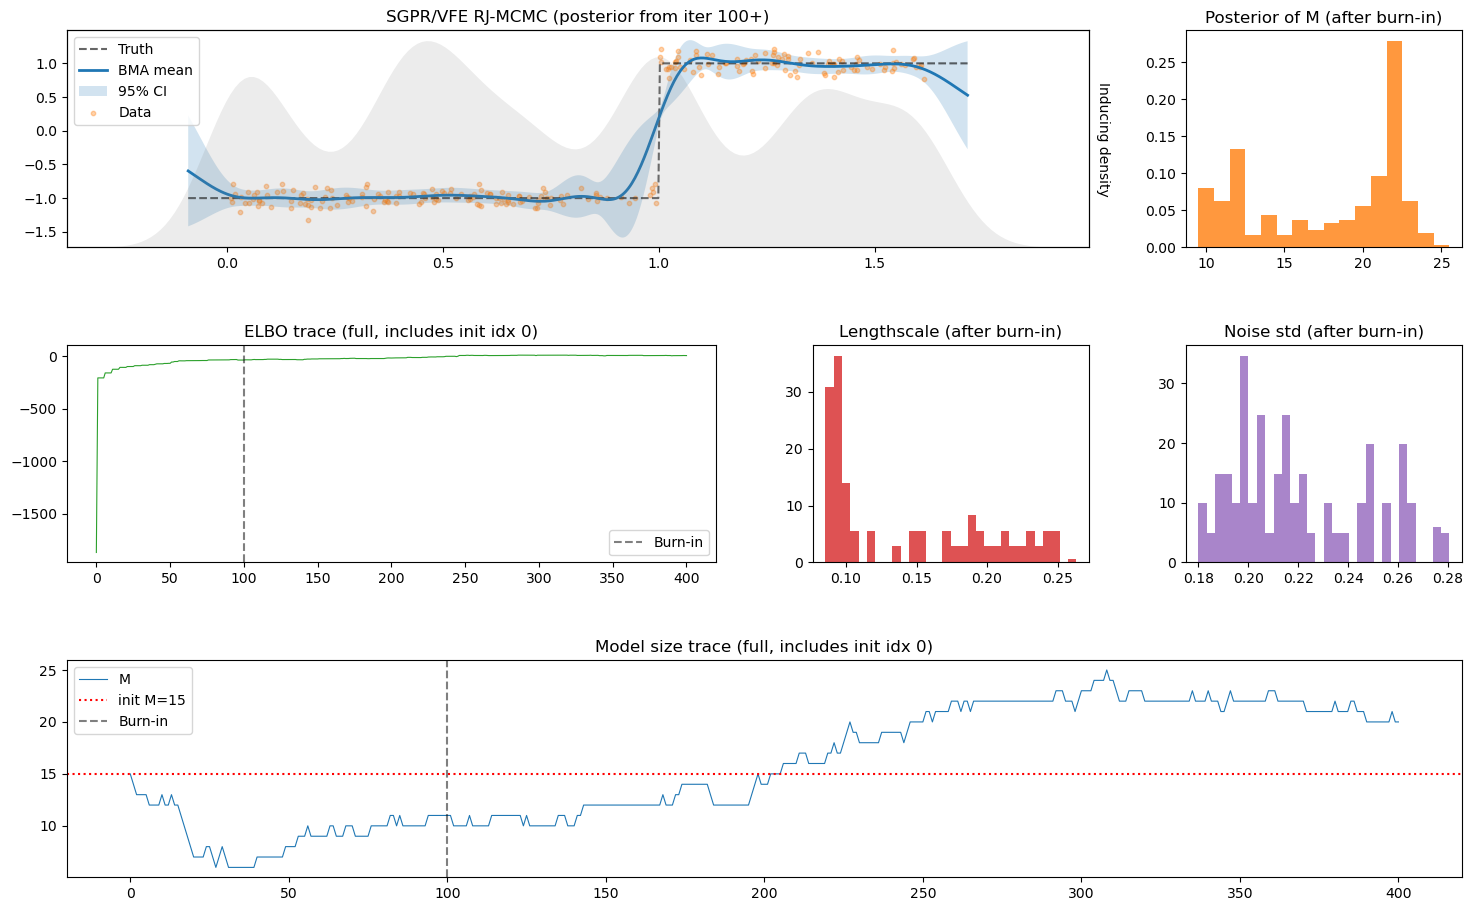


[2/3] 測試數據集: Sine Mix
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 1.30s
    平均誘導點數 M: 10.05 ± 1.81
    M 範圍: [8, 16]
    Metrics:
        RMSE: 0.1055
        MAE:  0.1002
        R²:   -4.1050
        NLPD: -0.5435


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_67145/3854127713.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


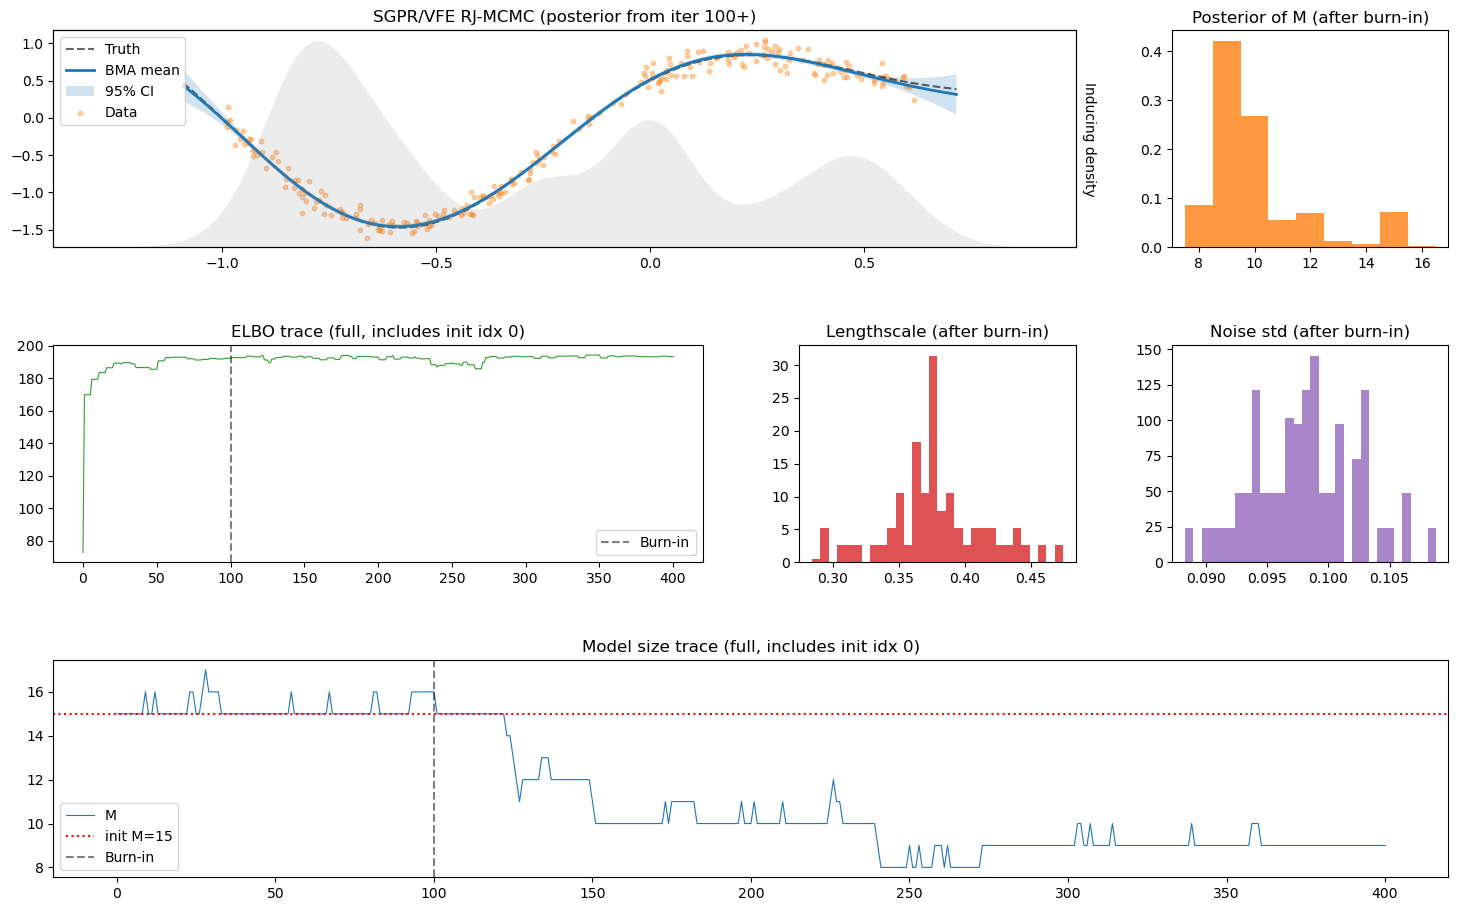


[3/3] 測試數據集: Multiscale
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 1.22s
    平均誘導點數 M: 14.11 ± 0.60
    M 範圍: [12, 16]
    Metrics:
        RMSE: 0.3313
        MAE:  0.2737
        R²:   -0.1035
        NLPD: -0.0319


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_67145/3854127713.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


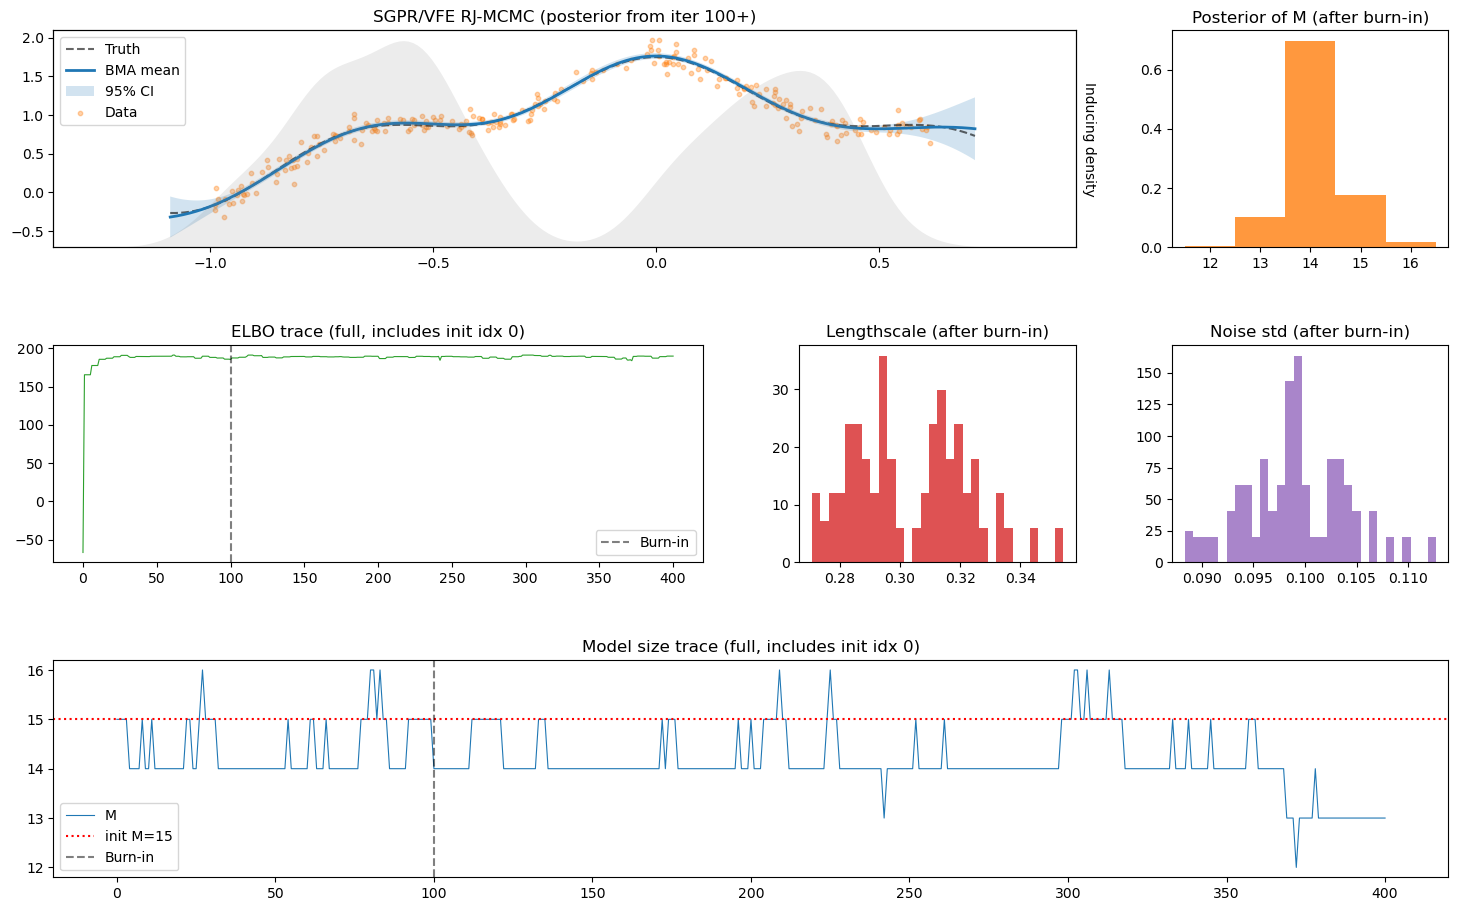


測試結果總結

數據集                  RMSE       MAE        R²           NLPD       Mean M     時間(s)     
------------------------------------------------------------------------------------------
Step Function        0.7299     0.6716     -319621260514.9622 0.9856     17.73      1.07      
Sine Mix             0.1055     0.1002     -4.1050      -0.5435    10.05      1.30      
Multiscale           0.3313     0.2737     -0.1035      -0.0319    14.11      1.22      

多數據集快速測試
將測試 3 個數據集
MCMC 參數: n_steps=200, burn_in=50

[1/3] 測試數據集: Step Function
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 1.10s
    平均誘導點數 M: 11.01 ± 1.46
    M 範圍: [8, 15]
    Metrics:
        RMSE: 0.5408
        MAE:  0.4814
        R²:   -175476581646.7870
        NLPD: 0.5197

[2/3] 測試數據集: Piecewise
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 0.15s
    平均誘導點數 M: 16.44 ± 0.74

/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_67145/3854127713.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


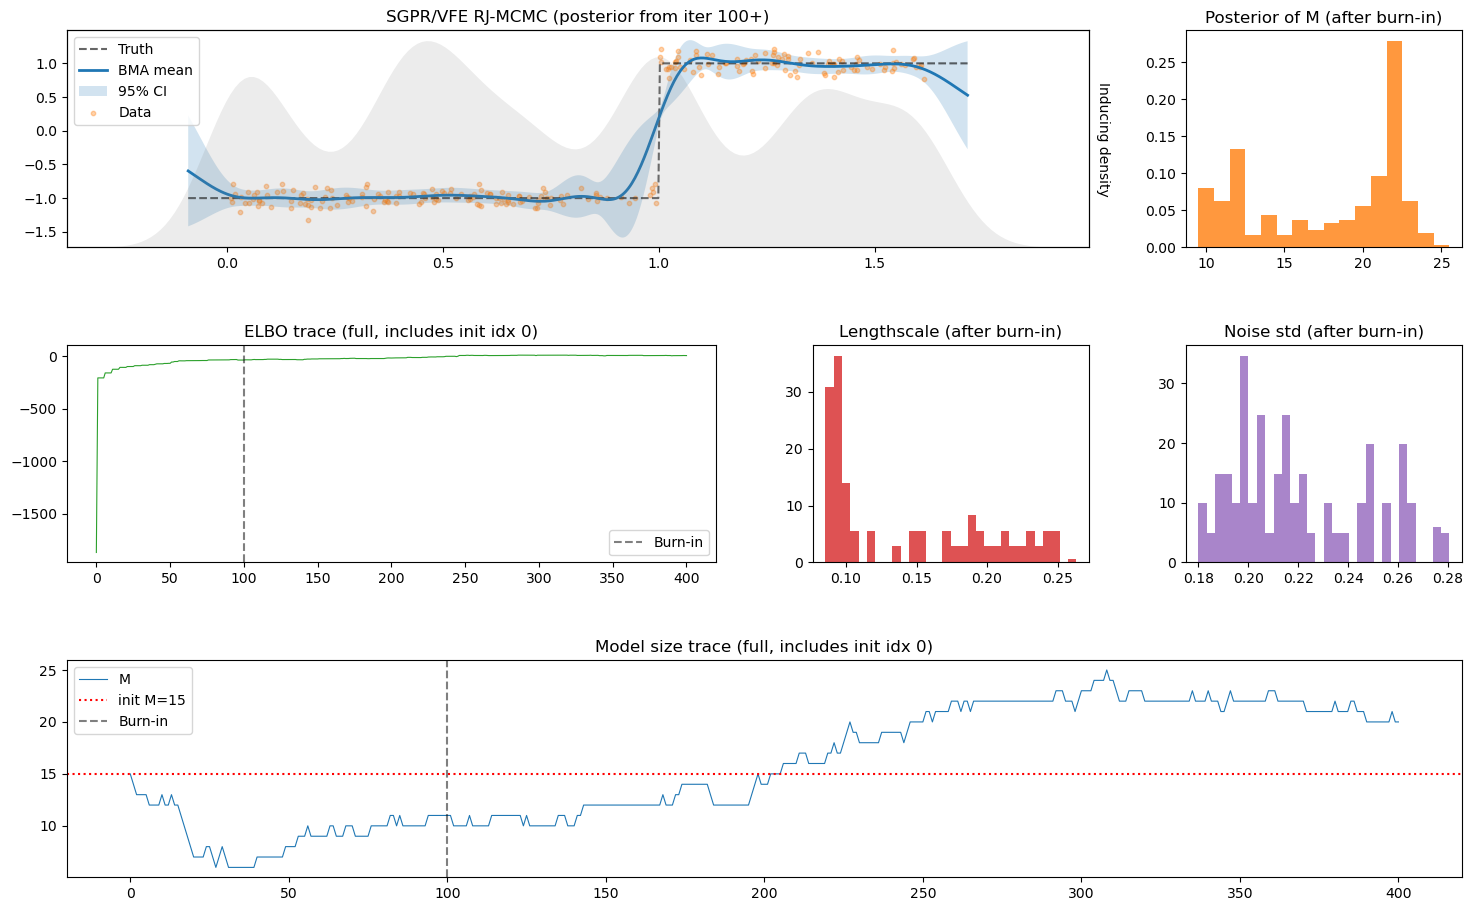


[2/2] 測試數據集: Piecewise
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 0.33s
    平均誘導點數 M: 16.13 ± 0.71
    M 範圍: [15, 18]
    Metrics:
        RMSE: 0.2645
        MAE:  0.2373
        R²:   -8.8007
        NLPD: 0.0069


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_67145/3854127713.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


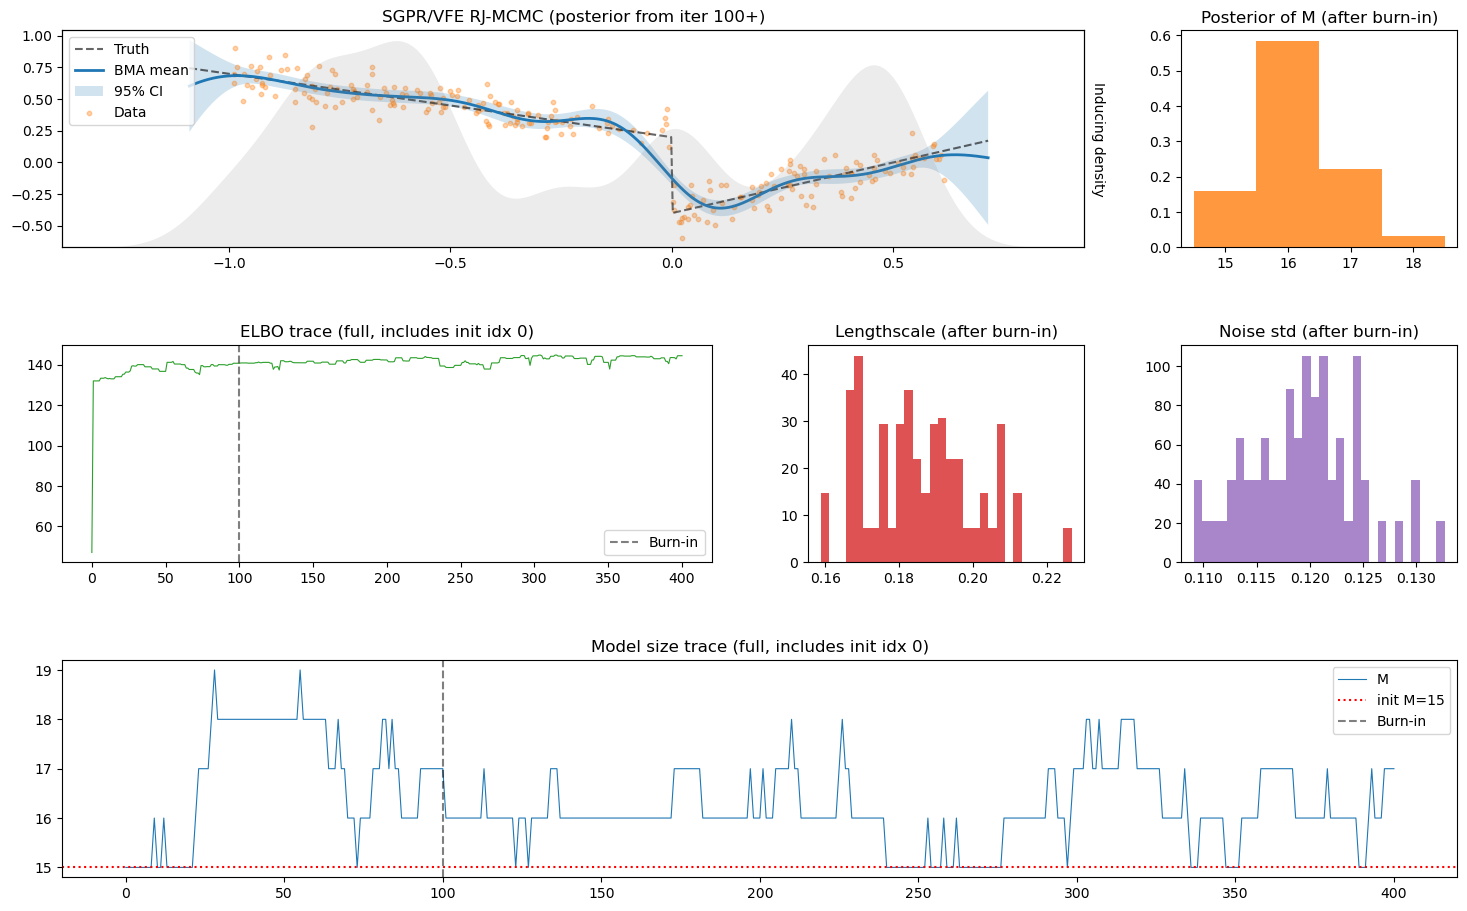


測試結果總結

數據集                  RMSE       MAE        R²           NLPD       Mean M     時間(s)     
------------------------------------------------------------------------------------------
Step Function        0.7299     0.6716     -319621260514.9622 0.9856     17.73      0.32      
Piecewise            0.2645     0.2373     -8.8007      0.0069     16.13      0.33      

測試類別: all (8 個數據集)
多數據集快速測試
將測試 8 個數據集
MCMC 參數: n_steps=300, burn_in=50

[1/8] 測試數據集: Step Function
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 0.24s
    平均誘導點數 M: 14.47 ± 4.67
    M 範圍: [8, 23]
    Metrics:
        RMSE: 0.6239
        MAE:  0.5662
        R²:   -233580697606.4253
        NLPD: 0.7115

[2/8] 測試數據集: Chirp Signal
--------------------------------------------------------------------------------
    數據大小: Train=240, Test=60
    運行時間: 0.32s
    平均誘導點數 M: 26.73 ± 1.57
    M 範圍: [22, 30]
    Metrics:
        RMSE: 0.6691
        MAE: 

In [21]:
# ============================================================
# 示例：測試多個數據集
# ============================================================

# 示例 1: 測試所有數據集（不繪圖，加快速度）
results_all = test_multiple_datasets(plot_results=False, n_steps=300, burn_in=50)

# 示例 2: 只測試幾個特定的數據集
results_subset = test_multiple_datasets(
    datasets_to_test=[
        ("Step Function", generate_step_data, 50),
        ("Sine Mix", generate_sine_mix_data, 60),
        ("Multiscale", generate_multiscale_data, 70),
    ],
    n_steps=400,
    burn_in=100,
    plot_results=True
)

# 示例 3: 快速測試（較少步數，不繪圖）
results_quick = test_multiple_datasets(
    datasets_to_test=[
        ("Step Function", generate_step_data, 50),
        ("Piecewise", generate_piecewise_data, 50),
        ("Bump", generate_bump_data, 55),
    ],
    n_steps=200,
    burn_in=50,
    plot_results=False
)

# 示例 4: 按類別測試 - 平滑函數
results_smooth = test_by_category('smooth', n_steps=400, burn_in=100, plot_results=False)

# 示例 5: 按類別測試 - 分段函數
results_piecewise = test_by_category('piecewise', n_steps=400, burn_in=100, plot_results=True)

# 示例 6: 按類別測試 - 所有數據集（快速版本）
results_all_quick = test_by_category('all', n_steps=300, burn_in=50, plot_results=False)

print("示例代碼已準備好。")
print("取消註釋上面的代碼來運行測試。")
print("\n可用的測試函數：")
print("  - test_multiple_datasets(): 測試指定的數據集列表")
print("  - test_by_category(): 按類別測試數據集")
print("  - quick_test(): 快速測試單個數據集")

Quick Test: RJ-MCMC with infodynamics-jax

[1/5] Generating test data...
    Train: X=(160, 1), y=(160, 1)
    Test: X=(40, 1), y=(40, 1)

[2/5] Configuring MCMC...
    Steps: 500, Burn-in: 100
    M_min: 5, M_max: 30, M_init: 10

[3/5] Running MCMC chain...

[4/5] Results:
    Runtime: 1.16s
    Mean M (post burn-in): 15.29 ± 2.61
    M range: [11, 20]
    Final ELBO: -9.65

[5/5] Computing metrics...
    Metrics:
        RMSE: 0.6698
        MAE: 0.6094
        R²: -179476122341.6808
        NLPD: 0.8872

[6/6] Plotting results...


/var/folders/3t/5987jhf1293c73dfhwt6jhx00000gn/T/ipykernel_67145/3854127713.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


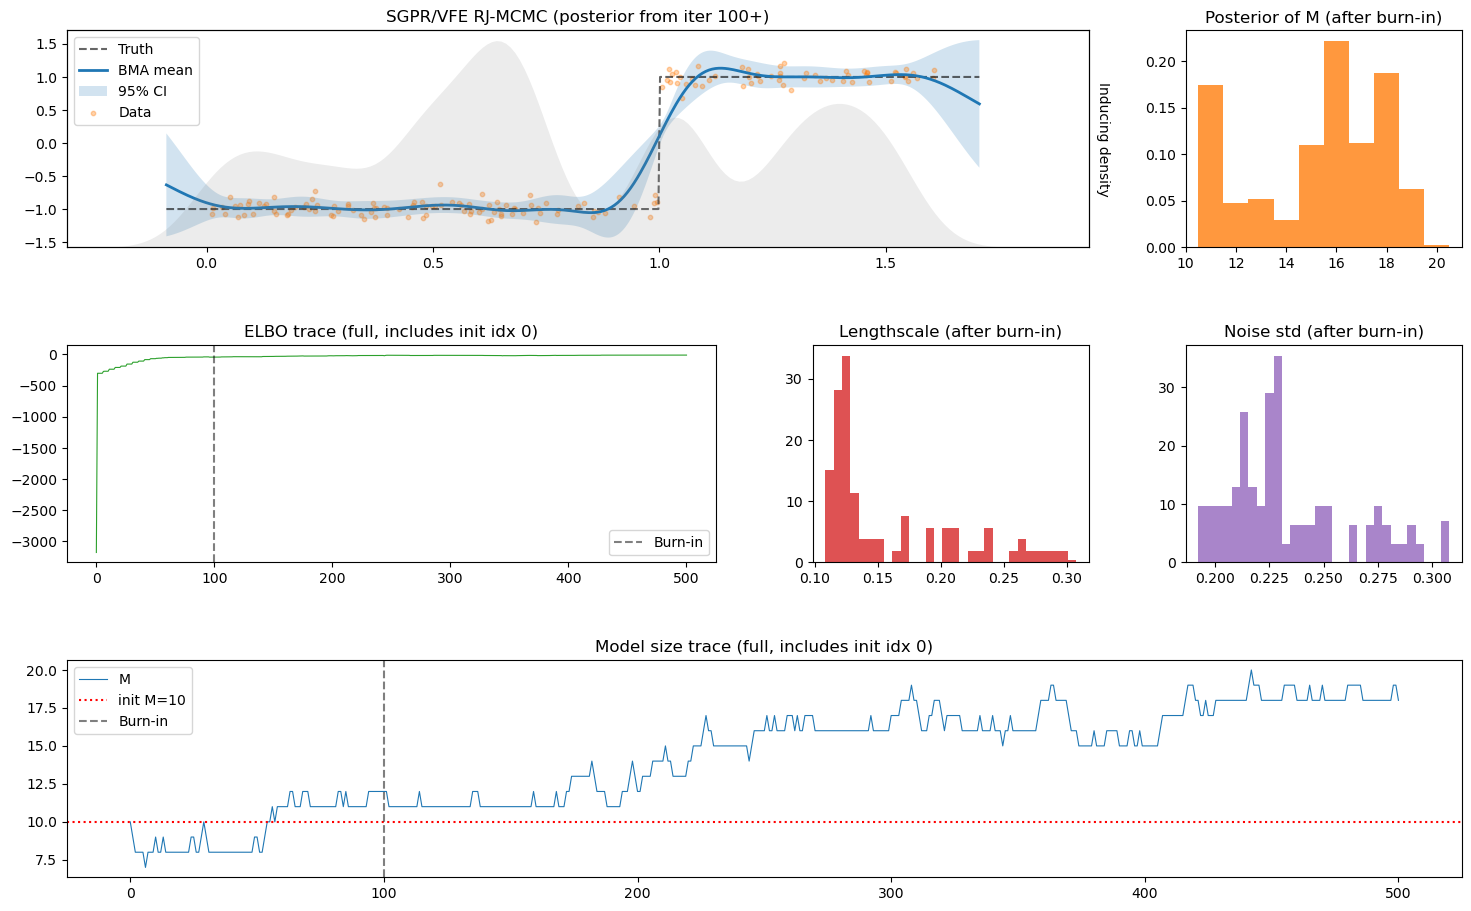

    Plotting completed!


In [20]:
# ============================================================
# 運行快速測試
# ============================================================

# 取消下面的註釋來運行測試
elbos, Ms, Thetas, Zs, M_init_val, metrics = quick_test()

## 重構說明

本 notebook 展示如何將自定義的 RJ-MCMC 實現重構為使用 `infodynamics-jax` 的組件。

**關鍵重構點：**
1. 使用 `infodynamics_jax.gp.kernels.rbf` 替代自定義 kernel
2. 使用 `Phi` 結構管理參數
3. 使用 `KernelParams` 統一參數格式
4. 保留高效的 rank-1 updates（這是實現細節，與庫核心無關）

**詳細重構指南：** 參見 `RJ_MCMC_REFACTORING_GUIDE.md`

**注意：** 由於完整的 RJ-MCMC 實現很長（800+ 行），這裡展示關鍵概念。
完整的重構版本應該參考原代碼和本指南。